# Google Colab

In [1]:
# !nvidia-smi -L
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import image
import shutil
from PIL import Image

In [2]:
from tensorflow.keras import utils, models, layers, optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import expand_dims
from datetime import datetime

In [ ]:
!pip freeze G tensorflow

In [ ]:
# !pip install tf-nightly

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!ls drive/MyDrive/Lemon_project/data

In [ ]:
cp -r drive/MyDrive/Lemon_project/data/ .

In [ ]:
train_data = utils.image_dataset_from_directory('drive/MyDrive/Lemon_project/data/class_images_min/Train_lemon', seed = 1,validation_split = 0.2, subset = 'training')
validation_data = utils.image_dataset_from_directory('drive/MyDrive/Lemon_project/data/class_images_min/Train_lemon', seed =1, validation_split = 0.2, subset = 'validation')

In [ ]:
# test_data = utils.image_dataset_from_directory('drive/MyDrive/Lemon_project/data/class_images_min/Test_lemon', seed = 1)

In [14]:
test_data = utils.image_dataset_from_directory('../raw_data/class_images_min/Test_lemon', seed = 1, batch_size=200)

Found 800 files belonging to 2 classes.


In [ ]:
pip freeze

# Add Random background

In [ ]:
from tensorflow import keras
from keras.engine import base_layer

K = keras.backend

def mask_lemon(lemon_array,bc_array):
    lemon_mask=lemon_array.sum(axis=2)>50
    current_mask=bc_array.copy()
    current_mask[lemon_mask,:]=0
    final_img_array=current_mask+lemon_array
    return final_img_array

class BackgroundClear(base_layer.BaseRandomLayer):

    def __init__(self, random_bc_path):
        super(BackgroundClear, self).__init__()
        self.bc_img_list = [np.array(Image.open(f"{random_bc_path}/{image_path}").resize((256,256))) for image_path in os.listdir(random_bc_path)]
        # get background
    def build(self, input_shape):
        self.original_shape = input_shape

    #@tf.function
    def call(self, inputs, is_training=None):

        is_training = K.learning_phase()

        if is_training is 1 or is_training is True:
            rng = np.random.default_rng()
            int_list=rng.integers(low=0, high=len(self.bc_img_list), size=inputs.shape[0])
            masked_img=np.array([mask_lemon(img.numpy(),self.bc_img_list[bc_id]) for img,bc_id in zip(inputs,int_list)])
            return masked_img
        else:
            return inputs

In [ ]:
# random_bc_path = 'drive/MyDrive/Lemon_project/data/backgrounds1'
# print(os.listdir(random_bc_path))
# print(image_path for image_path in os.listdir(random_bc_path))

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input



In [ ]:
def load_model():

    model = VGG16(weights='imagenet', include_top = False, input_shape=(256, 256, 3))
    model.trainable = False
    
    #list of layers
    flatten_layer = layers.Flatten()
    dense_layer = layers.Dense(500, activation='relu')
    dropout_layer = layers.Dropout(0.3)
    prediction_layer = layers.Dense(1, activation='sigmoid')
    
    #build layers
    model = models.Sequential([
        base_model,
        flatten_layer,
        dense_layer,
        dropout_layer,
        prediction_layer
    ])

    #compile
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model



In [ ]:
model = load_model()
model.summary()

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    # ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

In [ ]:
from tensorflow.keras import Input, Model



# def load_model():

#     VGG16model = VGG16(weights='imagenet', include_top = False, input_shape=(256, 256, 3))
#     model = models.Sequential()
#     #Ruby's Add Random Background layer
#     model.add(BackgroundClear(f'drive/MyDrive/Lemon_project/data/backgrounds1'))
    
#     #Normalize layer
#     model.add(preprocess_input())
#     # model.add(layers.Rescaling(1/255))
#     ### Augmentation Layer before Model
#     model.add(layers.RandomFlip())
#     model.add(VGG16model)
#     return model

In [ ]:
def VGG16_model():
  
    VGG16model = VGG16(weights='imagenet', include_top = False, input_shape=(256, 256, 3))
    VGG16model.trainable = False

    model_input = Input((256, 256, 3))
    x = BackgroundClear(f'drive/MyDrive/Lemon_project/data/backgrounds1')(model_input)
    x = preprocess_input(x)
    x = layers.RandomFlip()(x)
    x = VGG16model(x)

    x = layers.Flatten()(x)
    x = layers.Dense(500, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    model_output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs = model_input, outputs = model_output)
    opt = optimizers.Adam(learning_rate=1e-6)

    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model


In [ ]:
model = VGG16_model()
model.summary()

In [ ]:
es = EarlyStopping(patience=3, restore_best_weights = True)

histroy = model.fit(train_data, 
          batch_size=32, 
          epochs=120,
          validation_data = validation_data,
          callbacks=[es]
          )

In [ ]:
plot_loss_accuracy(histroy, title="loss accuracy for model")

In [9]:
test_data.__dict__.keys()

dict_keys(['_input_dataset', '_batch_size', '_drop_remainder', '_structure', '_metadata', '_variant_tensor_attr', '_graph_attr', '_options_attr', 'class_names', 'file_paths'])

In [10]:
test_data_list = test_data.__dict__['file_paths']

In [11]:
test_data_list[:10]

['../raw_data/class_images_min/Test_lemon/Healthy_lemon/0003_B_H_60_H.jpg',
 '../raw_data/class_images_min/Test_lemon/Unhealthy_lemon/0005_B_H_30_G.jpg',
 '../raw_data/class_images_min/Test_lemon/Healthy_lemon/0015_A_I_60_C.jpg',
 '../raw_data/class_images_min/Test_lemon/Unhealthy_lemon/0022_F_I_30_A.jpg',
 '../raw_data/class_images_min/Test_lemon/Healthy_lemon/0018_C_V_90_F.jpg',
 '../raw_data/class_images_min/Test_lemon/Unhealthy_lemon/0024_F_V_30_A.jpg',
 '../raw_data/class_images_min/Test_lemon/Unhealthy_lemon/0006_C_I_120_A.jpg',
 '../raw_data/class_images_min/Test_lemon/Unhealthy_lemon/0002_E_I_165_C.jpg',
 '../raw_data/class_images_min/Test_lemon/Healthy_lemon/0006_D_V_75_A.jpg',
 '../raw_data/class_images_min/Test_lemon/Unhealthy_lemon/0015_E_V_0_F.jpg']

In [ ]:
file_names = []
for file in test_data_list:
    file_names.append(file.split('/')[-2:])

file_names[:10]

In [4]:
model = models.load_model("../models/VGG16_model_1_Sep")

In [5]:
pred = model.predict(test_data)

In [ ]:
model.evaluate(validation_data, verbose=0)

In [ ]:
model.evaluate(test_data, verbose = 0)

In [ ]:
pred[:10]

In [ ]:
pred.shape
pred.ndim

In [ ]:
pred[0], pred[1]

In [ ]:
pred = pred.flatten()

In [ ]:
pred[:10]

In [ ]:
rows = [[round(pred[x],3), file_names[x]] for x in range(800)]

In [ ]:
len(file_names)

In [ ]:
pred_df = pd.DataFrame(rows,columns = ['pred','file_names'])

In [ ]:
pred_df = pred_df.sort_values(by=['pred'],ascending = False)

In [ ]:
plt.hist(pred_df['pred'])

In [ ]:
pred = model.predict(test_data)

In [7]:
!pip install sklearn

  Preparing metadata (setup.py) ... done
  Using cached scikit_learn-1.1.2-cp38-cp38-macosx_10_9_x86_64.whl (8.6 MB)
  Using cached threadpoolctl-3.1.0-py3-none-any.whl (14 kB)
  Using cached joblib-1.1.0-py2.py3-none-any.whl (306 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 5.6 MB/s eta 0:00:0000:0100:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=6eba3351bf808d95c8c01ca0f993414538c6f5f89a0b2786cff58a5b738d6ea4
  Stored in directory: /Users/lingchin/Library/Caches/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


              precision    recall  f1-score   support

           0       0.81      0.88      0.84        95
           1       0.89      0.81      0.85       105

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.84       200
weighted avg       0.85      0.84      0.85       200



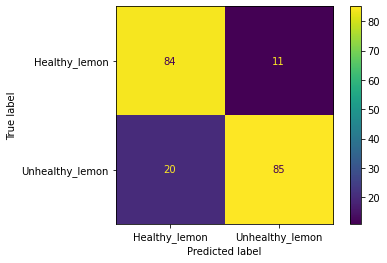

In [20]:
# Confusion Matrix

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, PrecisionRecallDisplay, precision_recall_curve

def predict_threshold(pred, threshold):
    if pred > threshold:
        return 1
    else:
        return 0

y_true_all = []
y_pred_all = []
y_pred_bin_all = []

for x_batch, y_batch in test_data.take(1).as_numpy_iterator():
    y_true = y_batch
    y_pred = model.predict(x_batch)
    y_pred_bin = np.vectorize(lambda pred: predict_threshold(pred, 0.9))(y_pred)
print(classification_report(y_true, y_pred_bin))
ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred_bin), display_labels = test_data.class_names).plot();

# find area that needs work in model

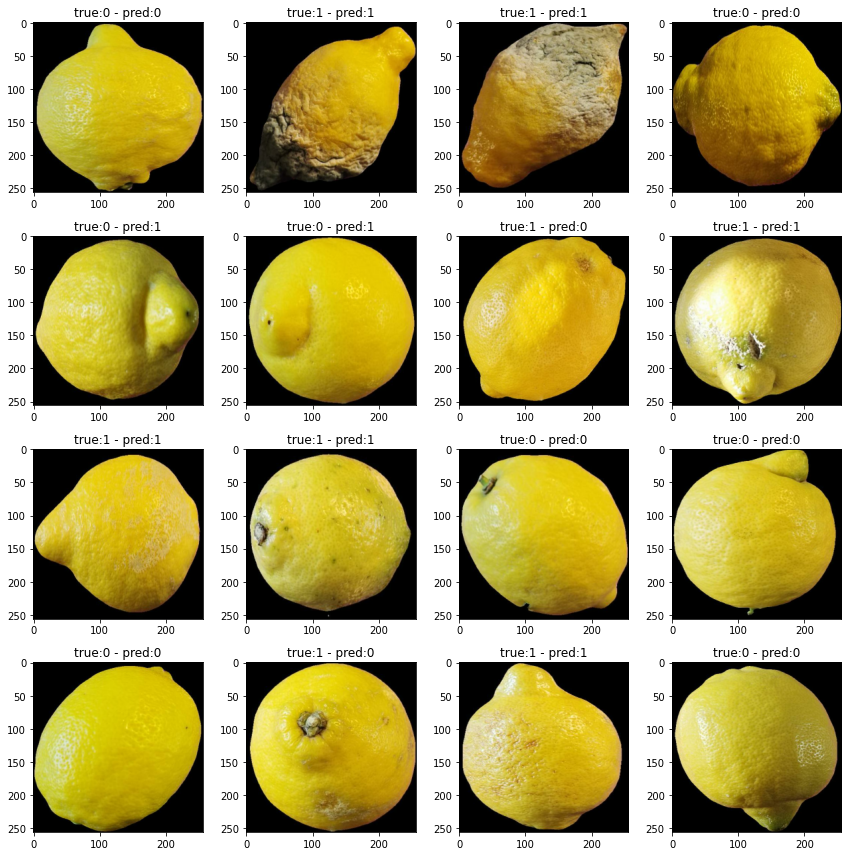

In [21]:
# plot some predictions
fig, axes = plt.subplots(4, 4, figsize = (12, 12))

for x_batch, y_batch in test_data.take(1).as_numpy_iterator():
    y_preds = model.predict(x_batch)
    for img, label, y_pred, ax in zip(x_batch, y_batch, y_preds, axes.flat):
        ax.imshow(np.squeeze(img)/255)
        ax.set_title(f'true:{int(label)} - pred:{predict_threshold(y_pred, 0.5)}')
plt.tight_layout();

In [ ]:
pred_df[pred_df['pred']>0.7]

In [ ]:
unhealthy_df = pred_df[pred_df['pred']>0.7]

In [ ]:
unhealthy_df.head()

In [ ]:
unhealthy_file_names = unhealthy_df['file_names'].tolist()
unhealthy_file_names[:10]




In [ ]:
# for file in unhealthy_file_names:
#     shutil.copy2(f"drive/MyDrive/Lemon_project/data/class_images_min/Test_lemon/Unhealthy_lemon/{file}",
#                  f"drive/MyDrive/Lemon_project/data/class_images_min/Test_lemon/test_unhealthy/{file}") 

In [ ]:
! ls

In [ ]:
datetime_stamp = datetime.now().strftime("%Y-%m-%d %I:%M %p")

models.save_model(model, f"drive/MyDrive/Lemon_project/models/VGG16_model{datetime_stamp}") #need to add time stamp

In [ ]:
!ls drive/MyDrive/Lemon_project/models

In [ ]:
directory_name = f"drive/MyDrive/Lemon_project/models/VGG16_model{datetime_stamp}"

In [ ]:
# zip -r models/VGG16_model.zip directory_name

In [ ]:
from google.colab import files
files.download(Lemon_project/models)